Example notebook to showcase the use of the eccDefinition module. Please do not commit your local changes

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import sys
sys.path.append("../")

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


Let's start by seeing which methods are currently implemented

In [2]:
available_methods = list(get_available_methods().keys())
print (available_methods)

['Amplitude', 'Frequency', 'ResidualAmplitude']


In the following, we will use these different methods and show what the measured eccentricity looks like. The wrapper function, measure_eccentricity, allows you to easily switch between methods.

In [3]:
help(measure_eccentricity)

Help on function measure_eccentricity in module measureEccentricity.measureEccentricity:

measure_eccentricity(tref_in, dataDict, method='Amplitude', return_ecc_method=False, spline_kwargs=None, extra_kwargs=None)
    Measure eccentricity and mean anomaly at reference time.
    
    parameters:
    ----------
    tref_in:
        Input Reference time at which to measure eccentricity and mean anomaly.
        Can be a single float or an array.
        However, if exclude_num_orbits_before_merger in extra_kwargs is not
        None, the interpolator used to measure eccentricty is constructed using
        extrema only upto exclude_num_orbits_before_merger and accorindly a
        tmax is set by chosing the min of time of last peak/trough. Thus the
        eccentricity and mean anomaly are computed only till tmax and a newr
        time array tref_out is returned with max(tref_out) = tmax.
    
    dataDict:
        Dictionary containing waveform modes dict, time etc.
        Should follo

### Loading waveform data

Let's now get some waveform data in the required format, using the handy load_waveform function.

In [4]:
help(load_waveform)

Help on function load_waveform in module measureEccentricity.load_data:

load_waveform(catalog='LAL', **kwargs)
    Load waveform from lvcnr file or LAL.
    
    parameters:
    ----------
    catalog:
          Waveform type. could be one of 'LAL', 'LVCNR', EOB
    
    kwargs:
         Kwargs to be passed to the waveform loading functions.



In [6]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDict = load_waveform(**waveform_keywords)

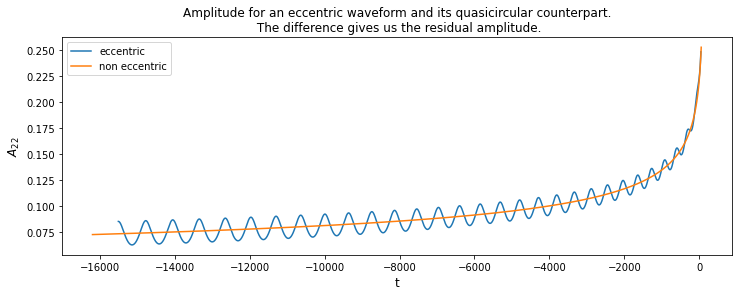

In [7]:
plt.figure(0, figsize=(12, 4))
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non eccentric")
plt.xlabel('t', fontsize=12)
plt.ylabel('$A_{22}$', fontsize=12)
plt.title('Amplitude for an eccentric waveform and its quasicircular counterpart.\n '
          'The difference gives us the residual amplitude.')
plt.legend();

### Measure eccentricity at a given tref

In [8]:
# Use the measure_eccentricity with your favorite method to 
# compute ecc and mean_ano at a given tref
tref = -12000
tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDict, method="Amplitude")
print (f"ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref}")

ecc=0.104 and mean_ano=5.951 at tref=-12000


### Now try all available methods

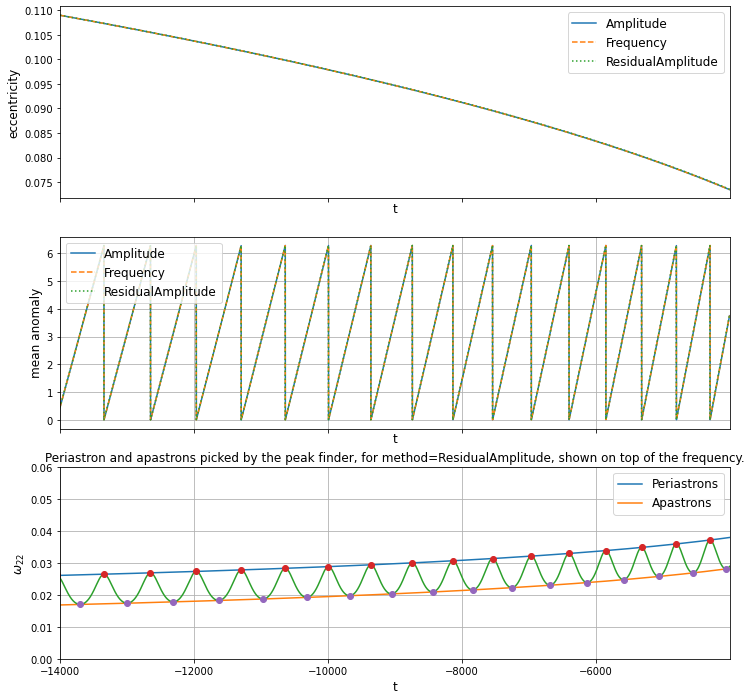

In [9]:
# refernce times at which to measure eccentricity and mean anomaly
tref_vec = np.arange(-14000, -4000)

fig, axarr = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
for method in available_methods:
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDict, method=method, 
                                                                      return_ecc_method=True,
                                                                     extra_kwargs={"debug": False})
    if method == available_methods[0]:
        ls = 'solid'
    elif method == available_methods[1]:
        ls = 'dashed'
    else:
        ls = 'dotted'
    axarr[0].plot(tref_vec, ecc_vec, label=method, ls=ls)
    axarr[1].plot(tref_vec, mean_ano_vec, label=method, ls=ls)
    
    if method == available_methods[-1]:
        # Plot omega(t) and peaks/troughs only for one case
        axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
        axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
        axarr[2].plot(eccMethod.t, eccMethod.omega22)
        axarr[2].plot(eccMethod.t[eccMethod.peaks_location], 
                      eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
        axarr[2].plot(eccMethod.t[eccMethod.troughs_location], 
                      eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);

axarr[0].set_xlabel("t", fontsize=12)
axarr[1].set_xlabel("t", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].set_ylim(0, 0.06)
axarr[2].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlabel("t", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12);

### Working on ET waveforms

In [10]:
import glob

In [11]:
!ls /home1/md.shaikh/etask_force/ET_sims/

Eccq1.__0._0.__et0.5_D27_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__-0.25__-0.25__et0.1_D14_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__0.25__0.25__et0.2_D16_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__-0.5_-0.5__et0.1_D13_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__0.5_0.5__et0.2_D15_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__-0.75_-0.75__et0.1_D13_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq1.__0.75_0.75__et0.2_D15_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Ecc_q2._0_0_0_0_0_0_et0.2_D16_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Eccq2.__0._0.__et0.5_D26_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Ecc_q4._0_0_0_0_0_0_et0.1_D12_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Ecc_q4._0_0_0_0_0_0_et0.2_D15_G80L_LFr_LB_NRPsi4_Strain_60modes.h5
Ecc_q4_0_0_0_0_0_0_et0.5_D27.5_G80L_LFr_LB_NRPsi4_Strain_60modes.h5


In [12]:
?load_waveform

Signature: load_waveform(catalog='LAL', **kwargs)
Docstring:
Load waveform from lvcnr file or LAL.

parameters:
----------
catalog:
      Waveform type. could be one of 'LAL', 'LVCNR', EOB

kwargs:
     Kwargs to be passed to the waveform loading functions.
File:      ~/Eccentricity/measureEccentricity/load_data.py
Type:      function


In [13]:
ETFiles = glob.glob("/home1/md.shaikh/etask_force/ET_sims/*.h5")

In [14]:
ETFiles

['/home1/md.shaikh/etask_force/ET_sims/Eccq1.__0.25__0.25__et0.2_D16_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Eccq1.__0._0.__et0.5_D27_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Ecc_q4._0_0_0_0_0_0_et0.1_D12_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Eccq1.__0.75_0.75__et0.2_D15_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Ecc_q4_0_0_0_0_0_0_et0.5_D27.5_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Eccq1.__-0.75_-0.75__et0.1_D13_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Eccq1.__-0.25__-0.25__et0.1_D14_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Ecc_q2._0_0_0_0_0_0_et0.2_D16_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/ET_sims/Eccq1.__-0.5_-0.5__et0.1_D13_G80L_LFr_LB_NRPsi4_Strain_60modes.h5',
 '/home1/md.shaikh/etask_force/

In [16]:
lvcnr_kwargs = {"filepath": ETFiles[0]}

In [17]:
dataDict = load_waveform("LVCNR", **lvcnr_kwargs)

In [18]:
dataDict

{'t': array([-2453.9480347 , -2452.95669953, -2451.96536435, ...,
          245.45764253,   246.4489777 ,   247.44031288]),
 'hlm': {(7,
   7): array([-7.36910102e-08+1.03480023e-08j, -6.69294029e-08+3.20606472e-08j,
          1.38158547e-08+7.27091322e-08j, ...,
         -1.23604313e-07-4.25669302e-08j, -1.31374247e-07-4.86680317e-08j,
         -1.40317030e-07-5.17537421e-08j]),
  (7,
   6): array([ 3.57572062e-07+8.27555689e-07j,  1.87166965e-07+8.93478828e-07j,
          5.78470858e-07+7.23883607e-07j, ...,
         -1.46887329e-06+1.03480150e-07j, -1.49566546e-06-7.83065978e-08j,
         -1.52379480e-06+7.25798646e-08j]),
  (7,
   5): array([-8.71090755e-09+3.47070642e-08j,  1.31680882e-08+3.32099267e-08j,
          2.35602364e-08+2.67779274e-08j, ...,
         -1.32755659e-07-1.71006374e-07j, -1.30150498e-07-1.89944630e-07j,
         -1.45214984e-07-1.96216581e-07j]),
  (7,
   4): array([-1.01285327e-06-6.02225015e-07j, -1.05696963e-06-5.18828957e-07j,
         -1.09544825e-06-4.

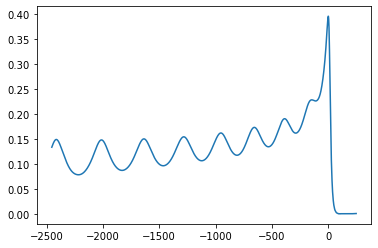

In [19]:
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]))

In [20]:
?measure_eccentricity

Signature:
measure_eccentricity(
    tref_in,
    dataDict,
    method='Amplitude',
    return_ecc_method=False,
    spline_kwargs=None,
    extra_kwargs=None,
)
Docstring:
Measure eccentricity and mean anomaly at reference time.

parameters:
----------
tref_in:
    Input Reference time at which to measure eccentricity and mean anomaly.
    Can be a single float or an array.
    However, if exclude_num_orbits_before_merger in extra_kwargs is not
    None, the interpolator used to measure eccentricty is constructed using
    extrema only upto exclude_num_orbits_before_merger and accorindly a
    tmax is set by chosing the min of time of last peak/trough. Thus the
    eccentricity and mean anomaly are computed only till tmax and a newr
    time array tref_out is returned with max(tref_out) = tmax.

dataDict:
    Dictionary containing waveform modes dict, time etc.
    Should follow the format:
        {"t": time, "hlm": modeDict, ...}
        with modeDict = {(l1, m1): h_{l1, m1},
      

In [21]:
tref_vec = np.arange(-2000, -400)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDict,"Amplitude", 
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100}})

In [22]:
eccMethod.omega22

array([0.04857364, 0.04864673, 0.04878852, ..., 0.01354897, 0.01371716,
       0.01382903])

In [23]:
eccMethod.phase22

array([-1.62577648e-01, -1.14424893e-01, -6.61272202e-02, ...,
        2.11260657e+02,  2.11274144e+02,  2.11287853e+02])

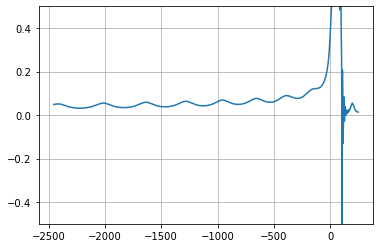

In [24]:
plt.plot(eccMethod.t, eccMethod.omega22)
plt.ylim(-0.5, 0.5)
plt.grid()

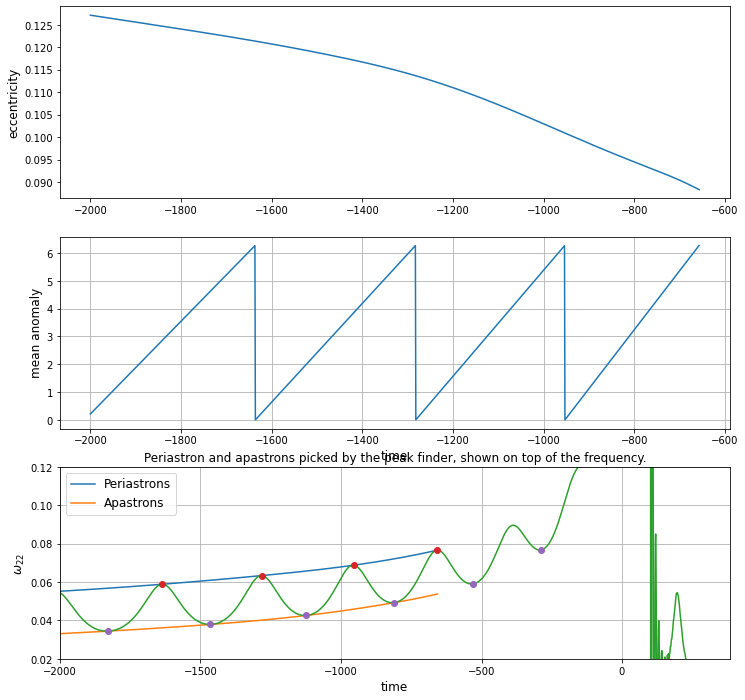

In [25]:
fig, axarr = plt.subplots(nrows=3, figsize=(12, 12))
axarr[0].plot(tref_out, ecc_vec)
axarr[1].plot(tref_out, mean_ano_vec)
axarr[1].set_xlabel("time", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()

axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[2].plot(eccMethod.t, eccMethod.omega22)
axarr[2].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[2].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[2].set_ylim(0.02, 0.12)
axarr[2].set_xlim(min(tref_vec),)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12)
axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

### Working on SXS waveform

In [26]:
SXS_Files = glob.glob("/home1/md.shaikh/etask_force/AEI_sxs_sims/*.h5")

In [27]:
SXS_Files

['/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q4_e095_D65_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q10_e01_D16_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q4_e035_D26_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q6_e01_D18_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SKS_q1.1_-0.4_-0.7_e025_D22_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q6_e02_D20_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SKS_q10_-0.75_0_e05_D28_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q1_e09_D70_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q8_e02_D20_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q3_e02_D17.3_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q4_e04_D28_Res3.h5',
 '/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q6_e095_D65_Res3.h5',
 '/home1/md

In [28]:
sxs_kwargs = {"filepath": SXS_Files[3]}

In [29]:
dataDictSXS = load_waveform("LVCNR", **sxs_kwargs)
SXS_Files[3]

'/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q4_e035_D26_Res3.h5'

In [30]:
tref_vec = np.arange(-12000, -100)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"Amplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100}})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:264: UserWarning: time array t_for_ecc_test is too long. Length is 114560
  warnings.warn("time array t_for_ecc_test is too long."


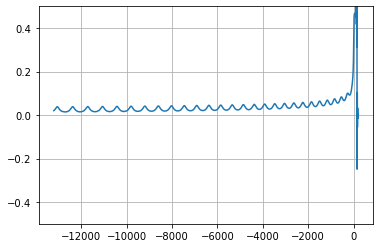

In [31]:
plt.plot(eccMethod.t, eccMethod.omega22)
plt.ylim(-0.5, 0.5)
plt.grid()

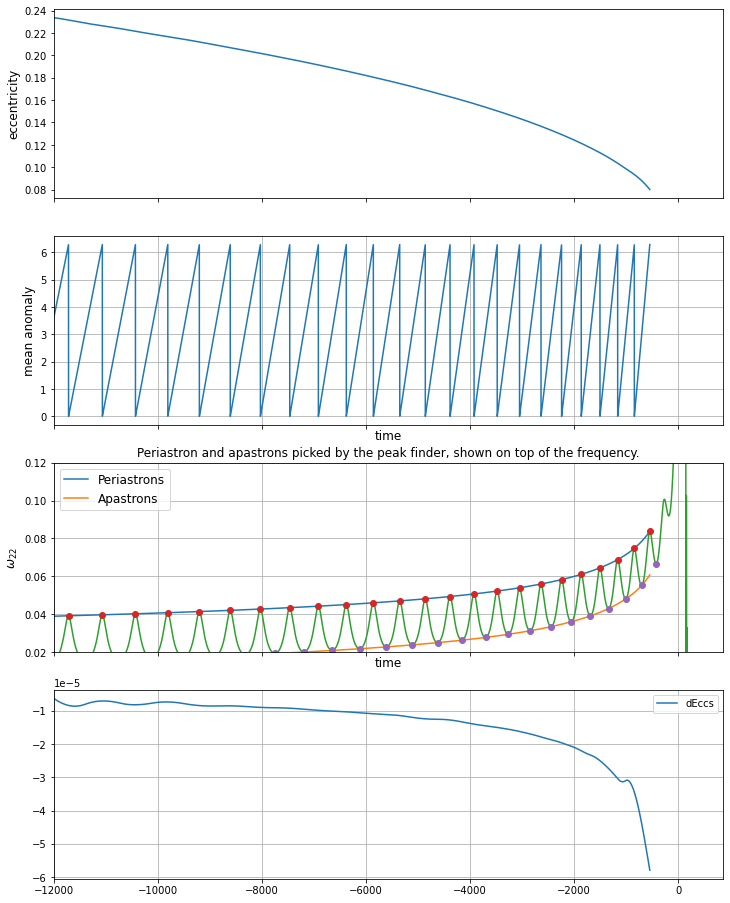

In [32]:
fig, axarr = plt.subplots(nrows=4, figsize=(12, 16), sharex=True)
axarr[0].plot(tref_out, ecc_vec)
axarr[1].plot(tref_out, mean_ano_vec)
axarr[1].set_xlabel("time", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()

axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[2].plot(eccMethod.t, eccMethod.omega22)
axarr[2].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[2].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[2].set_ylim(0.02, 0.12)
axarr[2].set_xlim(min(tref_vec),)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12)
axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

axarr[3].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[3].legend()
axarr[3].grid()

In [33]:
tref_out

array([-12000, -11999, -11998, ...,   -546,   -545,   -544])

### What happens if we set "num_orbits_to_exclude_before_merger" to 0 in "extra_keywords"

In [34]:
tref_vec = np.arange(-12000, 0)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"Amplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100},
                                                                     "num_orbits_to_exclude_before_merger": 0})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:264: UserWarning: time array t_for_ecc_test is too long. Length is 115800
  warnings.warn("time array t_for_ecc_test is too long."
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:274: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


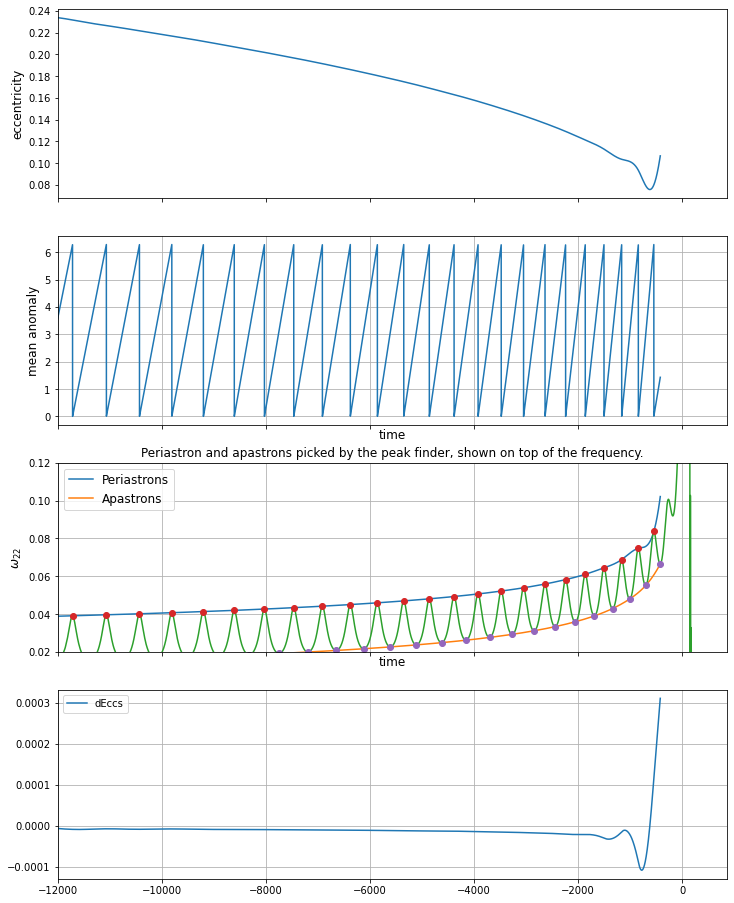

In [35]:
fig, axarr = plt.subplots(nrows=4, figsize=(12, 16), sharex=True)
axarr[0].plot(tref_out, ecc_vec)
axarr[1].plot(tref_out, mean_ano_vec)
axarr[1].set_xlabel("time", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()

axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[2].plot(eccMethod.t, eccMethod.omega22)
axarr[2].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[2].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[2].set_ylim(0.02, 0.12)
axarr[2].set_xlim(min(tref_vec),)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12)
axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

axarr[3].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[3].legend()
axarr[3].grid()

As we can see the eccentricty measurement in -1000 to -500 is bad. This is due to the fact that if we include data upto the mearger then the interpolation tries to fit also the merger peak and does some over fitting or something like that. That's why we by default remove one orbit before merger.

In [36]:
tref_out

array([-12000, -11999, -11998, ...,   -422,   -421,   -420])

In [37]:
eccMethod.extra_kwargs

{'extrema_finding_kwargs': {'width': 100,
  'height': None,
  'threshold': None,
  'distance': None,
  'prominence': None,
  'wlen': None,
  'rel_height': 0.5,
  'plateau_size': None},
 'num_orbits_to_exclude_before_merger': 0,
 'debug': True}

### What if "num_orbits_to_exclude_before_merger" is set to None

In [38]:
tref_vec = np.arange(-2000, -100)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"Amplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100},
                                                                     "num_orbits_to_exclude_before_merger": None})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:274: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


In [39]:
tref_out

array([-2000, -1999, -1998, ...,  -103,  -102,  -101])

Change tref_vec and try

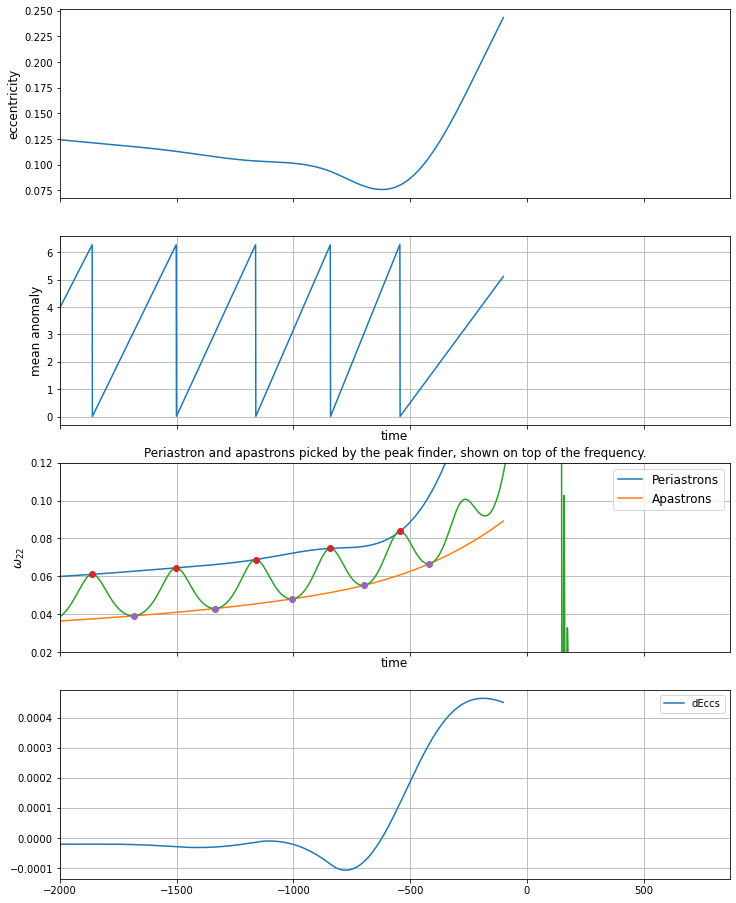

In [40]:
fig, axarr = plt.subplots(nrows=4, figsize=(12, 16), sharex=True)
axarr[0].plot(tref_out, ecc_vec)
axarr[1].plot(tref_out, mean_ano_vec)
axarr[1].set_xlabel("time", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()

axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[2].plot(eccMethod.t, eccMethod.omega22)
axarr[2].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[2].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[2].set_ylim(0.02, 0.12)
axarr[2].set_xlim(min(tref_vec),)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12)
axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

axarr[3].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[3].legend()
axarr[3].grid()